<a href="https://colab.research.google.com/drive/164ttLNWDiBifvahYRtdueJ9QdVRiLdFl?usp=sharing" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

In [ ]:
# Step 1: Install necessary packages
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Step 2: Load the TF-Flowers dataset
# Split the dataset into training (80%) and validation (20%)
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.9O09DX_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Step 3: Define preprocessing and batching
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
NUM_CLASSES = ds_info.features['label'].num_classes

# Function to resize and normalize images
def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    return image, label

# Apply preprocessing to datasets
train_ds = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
# Step 4: Build the model using EfficientNetB0 (feature extraction first)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

INPUT_SHAPE = IMG_SIZE + (3,)

# Load EfficientNetB0 with pre-trained ImageNet weights and exclude the top layer
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
base_model.trainable = False  # Freeze the base model for feature extraction

# Construct the full model with a classification head
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 5: Train the model (feature extraction phase)
model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 466ms/step - accuracy: 0.2507 - loss: 1.6119 - val_accuracy: 0.1635 - val_loss: 1.6570
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2455 - loss: 1.6103 - val_accuracy: 0.1635 - val_loss: 1.6558
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.2405 - loss: 1.6105 - val_accuracy: 0.1635 - val_loss: 1.6569
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.2417 - loss: 1.6094 - val_accuracy: 0.1635 - val_loss: 1.6530
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2431 - loss: 1.6081 - val_accuracy: 0.1635 - val_loss: 1.6539


Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 623ms/step - accuracy: 0.2927 - loss: 1.5770 - val_accuracy: 0.1635 - val_loss: 1.6901
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 127ms/step - accuracy: 0.5634 - loss: 1.2411 - val_accuracy: 0.1744 - val_loss: 1.6941
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7202 - loss: 0.9999 - val_accuracy: 0.1962 - val_loss: 1.6835
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 322ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.22      0.79      0.35       159
           1       0.11      0.12      0.12       120
           2       0.10      0.01      0.02       186
           3       0.25      0.01      0.01       138
           4       0.00      0.00      0.00       131

    accuracy                           0.20       734
   macro avg       0.14      0.19      0.10       734
weighted avg       0.14      0.20      0.10       734



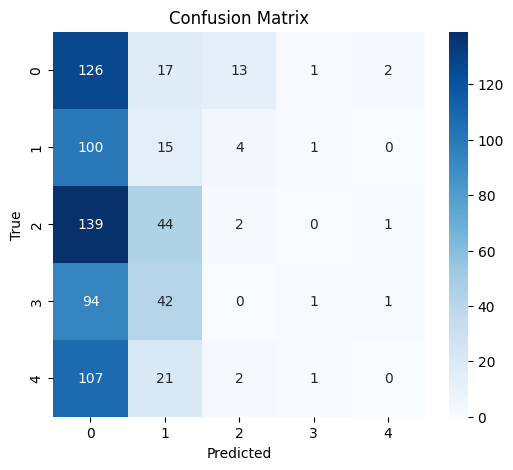

In [ ]:
# Step 6: Fine-tune the model (unfreeze base model)
base_model.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fine-tune for a few more epochs
model.fit(train_ds, validation_data=val_ds, epochs=3)

# Step 7: Evaluate the model on the validation set
# Get predicted logits and convert to predicted labels
y_pred_logits = model.predict(val_ds)
y_pred = np.argmax(y_pred_logits, axis=1)

# Extract true labels
y_true = np.concatenate([y for _, y in val_ds], axis=0)

# Step 8: Generate classification report and confusion matrix
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=range(NUM_CLASSES),
            yticklabels=range(NUM_CLASSES))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()